# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens. min (2, 30, 5)

In [178]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.make_ready import make_ready


In [179]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def add_data(word):
    ordet = 'data/' + word
    return ordet

In [216]:
filer = list(map(add_data, os.listdir('data/')))[0:40] # test 54:60 mellom 10 og 14 er noe feil
data = make_ready().use_stockstats(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [255]:
for i in range(len(data)):
    data[i] = data[i].fillna(.5)

In [253]:
data[0].fillna(0)

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,239.0,239.0,239.0,239.0,5179,5179,0.0,0.0,0.000000,...,239.000000,0.000000,0.000000,0.000000,239.000000,239.000000,0.0000,1.000000,1.000000,1.000000
1,9:1,239.2,239.2,239.2,239.2,180,180,239.0,0.2,0.000000,...,239.100000,0.004487,0.002493,0.001994,239.100000,239.100000,0.0000,1.000000,1.000000,1.000000
2,9:2,241.0,241.0,241.0,241.0,2396,2396,239.2,1.8,0.000000,...,239.733333,0.061535,0.026691,0.034845,239.733333,239.733333,0.0000,1.002649,1.002649,1.007525
3,9:3,242.2,242.2,242.2,242.2,3733,3733,241.0,1.2,0.000000,...,240.350000,0.129300,0.061450,0.067850,240.350000,240.350000,0.0000,1.002572,1.002572,1.004979
4,9:4,245.2,245.2,245.2,245.2,2865,2865,242.2,3.0,0.000000,...,241.320000,0.282776,0.127289,0.155487,241.320000,241.320000,0.0000,1.004036,1.004036,1.012386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16:16,240.4,240.4,240.4,240.4,14,14,240.2,0.2,1.137037,...,240.187500,0.254409,0.255595,-0.001187,239.526667,240.200000,0.2125,1.000278,1.000111,1.000833
373,16:17,240.4,240.4,240.4,240.4,2320,2320,240.4,0.0,1.137037,...,240.212500,0.251285,0.254733,-0.003448,239.580000,240.213333,0.1375,1.000223,1.000056,1.000000
374,16:18,240.4,240.4,240.4,240.4,433,433,240.4,0.0,1.137037,...,240.225000,0.245974,0.252981,-0.007008,239.640000,240.266667,0.0750,1.000250,1.000222,1.000000
375,16:19,239.6,239.6,239.6,239.6,5663,5663,240.4,-0.8,0.876858,...,240.225000,0.175192,0.237424,-0.062232,239.726667,240.266667,-0.0250,1.000362,1.000000,0.996672


In [256]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,239.0,239.0,239.0,239.0,5179,5179,0.5,0.5,0.500000,...,239.000000,0.000000,0.000000,0.000000,239.000000,239.000000,0.0000,1.000000,1.000000,1.000000
1,9:1,239.2,239.2,239.2,239.2,180,180,239.0,0.2,0.500000,...,239.100000,0.004487,0.002493,0.001994,239.100000,239.100000,0.0000,1.000000,1.000000,1.000000
2,9:2,241.0,241.0,241.0,241.0,2396,2396,239.2,1.8,0.500000,...,239.733333,0.061535,0.026691,0.034845,239.733333,239.733333,0.0000,1.002649,1.002649,1.007525
3,9:3,242.2,242.2,242.2,242.2,3733,3733,241.0,1.2,0.500000,...,240.350000,0.129300,0.061450,0.067850,240.350000,240.350000,0.0000,1.002572,1.002572,1.004979
4,9:4,245.2,245.2,245.2,245.2,2865,2865,242.2,3.0,0.500000,...,241.320000,0.282776,0.127289,0.155487,241.320000,241.320000,0.0000,1.004036,1.004036,1.012386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16:16,240.4,240.4,240.4,240.4,14,14,240.2,0.2,1.137037,...,240.187500,0.254409,0.255595,-0.001187,239.526667,240.200000,0.2125,1.000278,1.000111,1.000833
373,16:17,240.4,240.4,240.4,240.4,2320,2320,240.4,0.0,1.137037,...,240.212500,0.251285,0.254733,-0.003448,239.580000,240.213333,0.1375,1.000223,1.000056,1.000000
374,16:18,240.4,240.4,240.4,240.4,433,433,240.4,0.0,1.137037,...,240.225000,0.245974,0.252981,-0.007008,239.640000,240.266667,0.0750,1.000250,1.000222,1.000000
375,16:19,239.6,239.6,239.6,239.6,5663,5663,240.4,-0.8,0.876858,...,240.225000,0.175192,0.237424,-0.062232,239.726667,240.266667,-0.0250,1.000362,1.000000,0.996672


In [257]:
def prepare_data_for_training(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
    
dataxes, datayes = prepare_data_for_training(data)


In [258]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(dataxes, datayes, test_size=0.33, shuffle=True, random_state=42)
X_train.shape

(8655, 30, 5)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [259]:
model = Sequential()

model.add(LSTM(units=64, input_dim=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score])

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, None, 64)          17920     
_________________________________________________________________
dropout_52 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                650       
Total params: 51,594
Trainable params: 51,594
Non-trainable params: 0
_________________________________________________________________


In [260]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, verbose=1)

Train on 8655 samples, validate on 4264 samples
Epoch 1/60
8655/8655 [==============================] - 12s 1ms/sample - loss: 0.1579 - mae: 0.2698 - r2_score: 0.4442 - val_loss: 0.1276 - val_mae: 0.2386 - val_r2_score: 0.5731
Epoch 2/60
8655/8655 [==============================] - 8s 903us/sample - loss: 0.1213 - mae: 0.2384 - r2_score: 0.5655 - val_loss: 0.1146 - val_mae: 0.2278 - val_r2_score: 0.6142
Epoch 3/60
8655/8655 [==============================] - 8s 934us/sample - loss: 0.1122 - mae: 0.2304 - r2_score: 0.5963 - val_loss: 0.1088 - val_mae: 0.2249 - val_r2_score: 0.6282
Epoch 4/60
8655/8655 [==============================] - 8s 921us/sample - loss: 0.1054 - mae: 0.2234 - r2_score: 0.6236 - val_loss: 0.1022 - val_mae: 0.2182 - val_r2_score: 0.6505
Epoch 5/60
8655/8655 [==============================] - 8s 975us/sample - loss: 0.1029 - mae: 0.2197 - r2_score: 0.6353 - val_loss: 0.0975 - val_mae: 0.2135 - val_r2_score: 0.6641
Epoch 6/60
8655/8655 [==============================]

Epoch 46/60
8655/8655 [==============================] - 9s 1ms/sample - loss: 0.0354 - mae: 0.1336 - r2_score: 0.8699 - val_loss: 0.0348 - val_mae: 0.1316 - val_r2_score: 0.8775
Epoch 47/60
8655/8655 [==============================] - 9s 1ms/sample - loss: 0.0334 - mae: 0.1300 - r2_score: 0.8781 - val_loss: 0.0347 - val_mae: 0.1321 - val_r2_score: 0.8781
Epoch 48/60
8655/8655 [==============================] - 10s 1ms/sample - loss: 0.0339 - mae: 0.1309 - r2_score: 0.8768 - val_loss: 0.0337 - val_mae: 0.1290 - val_r2_score: 0.8819
Epoch 49/60
8655/8655 [==============================] - 11s 1ms/sample - loss: 0.0325 - mae: 0.1281 - r2_score: 0.8819 - val_loss: 0.0336 - val_mae: 0.1300 - val_r2_score: 0.8819
Epoch 50/60
8655/8655 [==============================] - 9s 1ms/sample - loss: 0.0323 - mae: 0.1279 - r2_score: 0.8829 - val_loss: 0.0321 - val_mae: 0.1264 - val_r2_score: 0.8874s:
Epoch 51/60
8655/8655 [==============================] - 9s 1ms/sample - loss: 0.0318 - mae: 0.1266 -

### Plotte validation kurve

max val_r2 0.9439998269081116


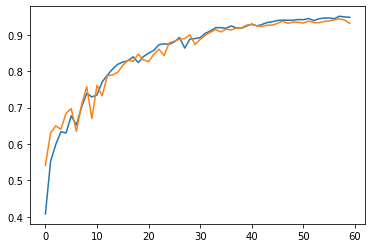

In [145]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
#plt.xlim(50,100)
#plt.ylim(0.0, 0.025)
print(f"max val_r2 {np.max(history.history['val_r2_score'])}")

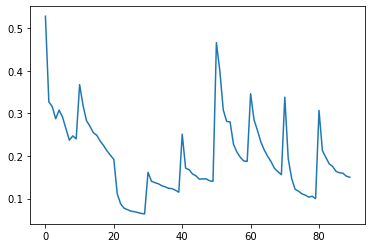

In [265]:
#plt.plot(history.history['loss'])
flatten = [j for sub in all_history for j in sub]
#all_history
#for h in all_history:
plt.plot(flatten)

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [169]:
filer = list(map(add_data, os.listdir('data/')))[55:60] # test 54:60
data_test = make_ready().use_stockstats(filer)
dataxes, datayes = prepare_data_for_test(data_test)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [170]:
pred = []

for x in dataxes:
    pred.append(model.predict(x))

pred = np.array(pred)

C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [171]:
for i in range(len(pred)):
    print(f"rscore for one of it {r2_score(pred[i], datayes[i])}")
    

rscore for one of it 0.578028159334887
rscore for one of it 0.23117419961225796
rscore for one of it 0.709349975077281
rscore for one of it -0.1874100602546584
rscore for one of it 0.5287478640105717


In [159]:
pred.shape

(2,)

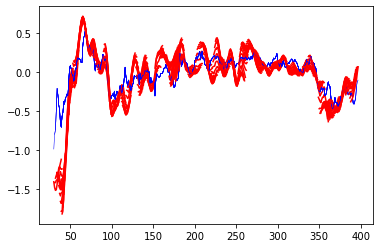

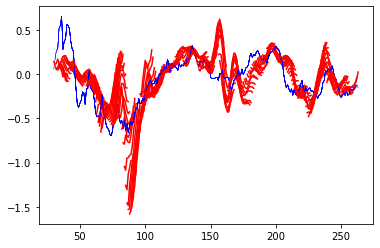

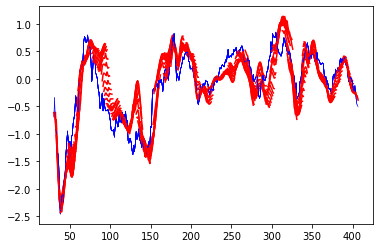

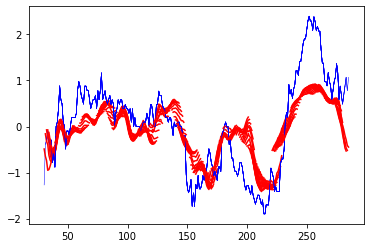

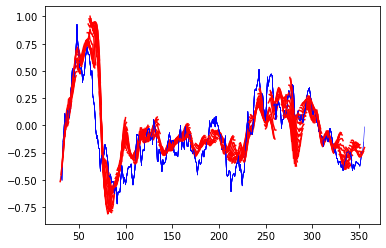

In [172]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):
        
    #print(p.shape)
        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

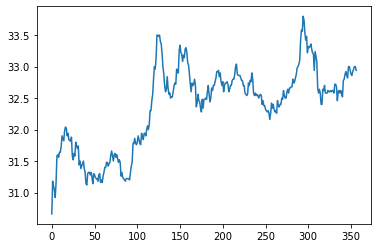

In [39]:
plt.plot(data[0]['open'])

## Save model

In [152]:
# Save model

model.save('models/rnn_model.h5')

In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
